# Classification
## MNIST
MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

Scikit-Learn provides many helper functions to download popular datasets like MNIST.

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- DESR key: describing the dataset.
- data key: containing an array with one row per instance and one column per feature.
- target key: containing an array with the labels.

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

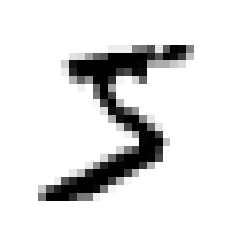

In [8]:
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation ="nearest")
plt.axis('off')
plt.show()

That looks like a 5.

In [9]:
y[0]

'5'

In [10]:
import numpy as np
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
Let's only try to identify one digit - for example the number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [12]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### Stochastic Gradient Descent (SGD)

Scikit-Learn's SGDClassifier class has the advantage of being capable of handling very large datasets efficiently.
Strictly speaking, SGD is merely an optimization technique and does not correspond to a specific family of machine learning models. It is only a way to train a model.

For example, using SGDClassifier(loss='log') results in logistic regression, i.e. a model equivalent to LogisticRegression which is fitted via SGD instead of being fitted by one of the other solvers in LogisticRegression.

The advantages of Stochastic Gradient Descent are:
- Efficiency.
- Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:
- SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
- SGD is sensitive to feature scaling.

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor.

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation.

#### Implementing Cross-Validation
The following code does roughly the same thing as Scikit-Learn's cross_val_score() function, and prints the same result:

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [17]:
skfolds = StratifiedKFold(n_splits=3, random_state = 42)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [18]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and make predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(sgd_clf, X_train, y_train_5, cv =3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.base import BaseEstimator

In [22]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype = bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring= "accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Condusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() function performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set.

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class), the second row considers the images of 5s (the positive class). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal.

In [28]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

__Precision__: Accuracy of the positive predictions.

precision = TP/(TP + FP)

TP is the number of true positives, and FP is the number of false positives.

__Recall__: Sensitivity or true positive rate (TPR).

recall = TP/(TP + FN)

FN is the number of false negatives.

<img src ="https://media.geeksforgeeks.org/wp-content/uploads/20200821144709/284.PNG" width = "600">

### Precision and Recall

In [29]:
from sklearn.metrics import precision_score, recall_score

In [30]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [31]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

__F1 score__: It is the harmonic mean of precision and recall. The harmonic mean gives much more weight to low values.

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Tradeoff
SGDClassifier computes a score basef on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier's predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.

In [34]:
y_scores = sgd_clf.decision_function([some_digit])

In [35]:
y_scores

array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

To decide which threshold to use, we will first need to get the scores of all instances in the training set using cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions.

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

Now with these scores we can compute precision and recall for all possible thresholds using precision_recall_curve() function.

In [39]:
from sklearn.metrics import precision_recall_curve

In [40]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [41]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")

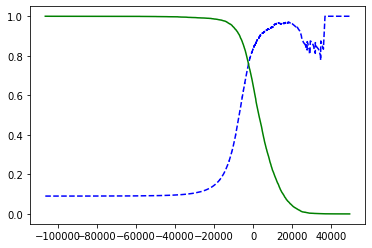

In [42]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

In [43]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [44]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [45]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [46]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve
The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers. The ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is equal to 1 minus true negative rate (TNR). The TNR is also called specificity. Hence the ROC curve plot sensitivity (recall) versus 1-specificity.

To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function:

In [47]:
from sklearn.metrics import roc_curve

In [48]:
fpr, tpr , thresholds = roc_curve(y_train_5, y_scores)

In [49]:
%matplotlib inline
def plot_roc_curve(fpr, tpr, label = None):
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")

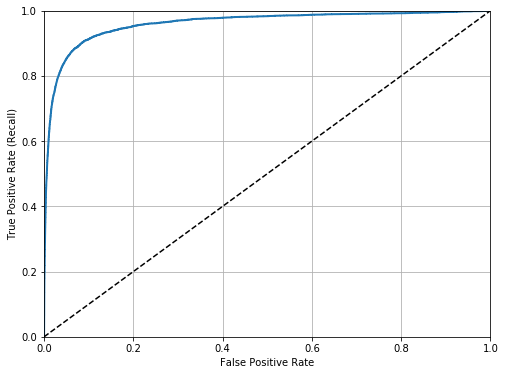

In [50]:
plot_roc_curve(fpr, tpr)
plt.show()

A good classifier stays as far away from that the dotted line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal 1, whereas a purely classifier will have a ROC AUC equal to 0.5

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

__Note__: As a rule of thumb, we should prefer the precision/recall curve whenever the positive class is rare or when we care more about the false positives than the false negatives, and the ROC curve otherwise.

__RandomForestClassifier__ class does not have a decision_function() method, instead it has a predict_proba method.

The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g. 70% chance that the image represents a 5).

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [55]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

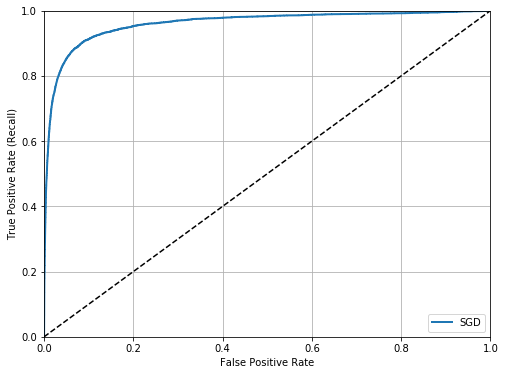

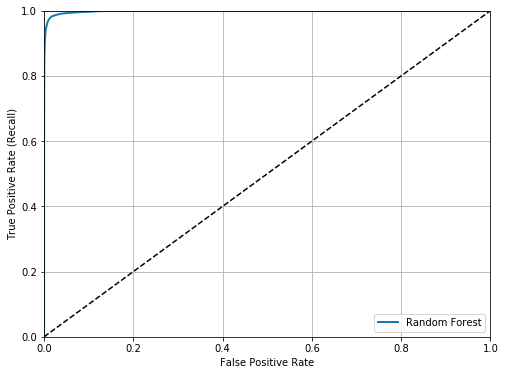

In [56]:
plot_roc_curve(fpr, tpr, "SGD")
plt.legend(loc = "lower right")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

The RandomForestClassifier's ROC curve looks much better than the SGDClassifier's: it comes much closer to the top-left corner.

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [58]:
tpr_forest = 1- fpr_forest
precision = tpr_forest

In [59]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv =3)

In [60]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification
Whereas binary classifiers distinguish between two classes, multiclass classfiers (also called multinomial classifiers) can distinguish between more than two classes. 

Some algorithms (such as Random Forest Classifiers or Naive Bayes Classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

Scikit-Learn detects when we try to use a binary classification algorithm for a multiclass classification task, and it automatically runs One vs All strategy (except for SVM classifiers which it uses One vs One strategy).

In [62]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [64]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [65]:
y_train[0]

5

In [66]:
np.argmax(some_digit_scores)

3

In [67]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [68]:
sgd_clf.classes_[5]

5

In [69]:
from sklearn.svm import SVC

In [70]:
svm_clf = SVC(gamma="auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [71]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

If we want to force Scikit-Learn to use one-versus-one or one-versus-all, we can use the OneVsOneClassifier or OneVsRestClassifier classes.

In [72]:
from sklearn.multiclass import OneVsOneClassifier

In [73]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [74]:
len(ovo_clf.estimators_)

45

In [75]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes.

In [76]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [77]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring ="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [82]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv =3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [83]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's __matshow()__ function.

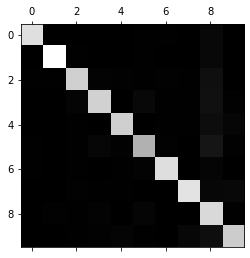

In [84]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [86]:
row_sums = conf_mx.sum(axis =1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

Now, let's fill the diagonal with zeros to keep only the errors, and let's plot the result:

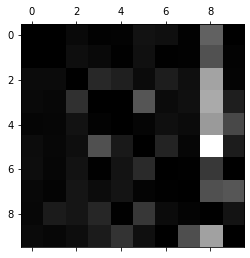

In [87]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Analyzing the confusion matrix can often give yuo insights on ways to improve our classifier. Looking at this plot, it seems that our efforts should be spend on reducing the false 8s.

Analyzing individual errors can also be a good way to gain insights on what our classifier is doing and why it is failing, but it is more difficult and time-consuming.

In [88]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [89]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

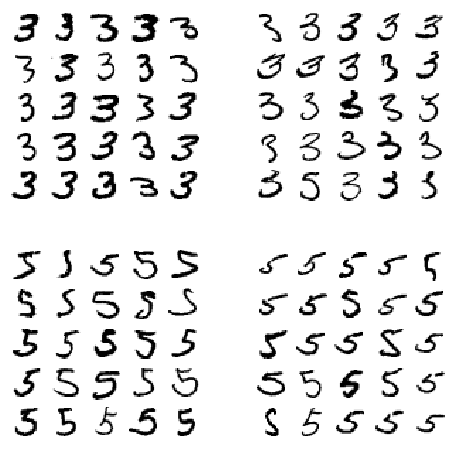

In [90]:
plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

## Multilabel Classification
A Classification system that outputs multiple binary tags is called a multilabel classification system.

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
y_train_large =(y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [94]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

KNeighborsClassifier instance supports multilabel classification, but not all classifiers do and we train it using the multiple target arrays.

In [95]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [96]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605

## Multioutput Classification
It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [97]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [99]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [108]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[12]])

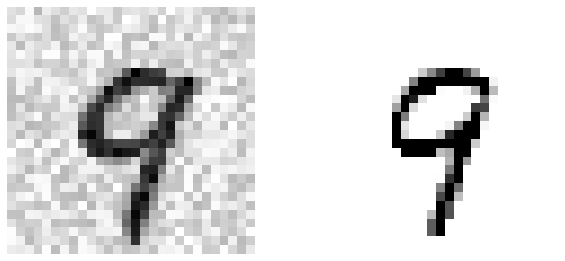

In [115]:
plt.figure(figsize = (10,10))
plt.subplot(221); plot_digit(X_test_mod[12])
plt.subplot(222); plot_digit(clean_digit)

Looks close enough to our target!